In [22]:
import sys
import os
import vamb
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

In [10]:
PATH_VAMB = '/Users/nmb127/Documents/vamb'
PATH_VAMB_DATA = '/Users/nmb127/Documents/vamb_data'

In [11]:
def parse_logfile(filepath):
    results = defaultdict(list)
    with open(f'{PATH_VAMB}/{filepath}') as f:
        for line in f:
            if line.startswith('loss_vamb'):
                for metric in line.split(', '):
                    k, v = metric.split(' ')
                    results[k].append(float(v))
    return results

In [33]:
def filterclusters(clusters, lengthof):
    filtered_bins = dict()
    for medoid, contigs in clusters.items():
        binsize = sum(lengthof[contig] for contig in contigs)
    
        if binsize >= 200000:
            filtered_bins[medoid] = contigs
    
    return filtered_bins

In [30]:
contig_path = f'{PATH_VAMB_DATA}/data/airways/contigs.fna'
with vamb.vambtools.Reader(contig_path, 'rb') as filehandle:
    tnfs, CONTIGNAMES, LENGTHS = vamb.parsecontigs.read_contigs(filehandle)
rpkms = vamb.vambtools.read_npz(f'{PATH_VAMB_DATA}/data/airways/abundance.npz')
vae = vamb.encode.VAE(nsamples=rpkms.shape[1])
_, MASK = vamb.encode.make_dataloader(rpkms, tnfs)

In [17]:
reference_path = f'{PATH_VAMB_DATA}/data/airways/reference.tsv'

!head $reference_path # show first 10 lines of reference file

with open(reference_path) as reference_file:
    REFERENCE = vamb.benchmark.Reference.from_file(reference_file)

S23C236194	OTU_97.38699.0	CP013953.1	405835	408637
S23C27593	OTU_97.44406.0	CP015430.1	1591817	1594726
S23C53437	OTU_97.35057.0	CP012974.1	260542	266700
S23C191539	OTU_97.16597.0	CP010116.1	1675948	1678686
S23C111210	OTU_97.20680.0	CP013619.1	408162	411064
S23C216129	OTU_97.409.0	CP013957.1	103779	106015
S23C2782	OTU_97.45246.0	CP007573.1	1941619	1956892
S23C9729	OTU_97.44851.0	CP015426.1	1099587	1121671
S23C36165	OTU_97.409.0	CP013957.1	427732	429801
S23C90379	OTU_97.2104.0	CP019196.1	300725	303071


In [57]:
def save_clusters(filepath, cluster_path, indices=None):
    print(filepath)
    latent_labels = np.load(f'{PATH_VAMB}/{filepath}')
    if indices:
        print(len(indices))
        contignames, mask, lengths = \
            np.array(CONTIGNAMES)[indices], np.array(MASK)[indices], np.array(LENGTHS)[indices]
    else:
        contignames, mask, lengths = CONTIGNAMES, MASK, LENGTHS
    filtered_labels = [n for (n,m) in zip(contignames, mask) if m]
    cluster_iterator = vamb.cluster.cluster(latent_labels, labels=filtered_labels)
    clusters = dict(cluster_iterator)

    medoid, contigs = next(iter(clusters.items()))
    print('First key:', medoid, '(of type:', type(medoid), ')')
    print('Type of values:', type(contigs))
    print('First element of value:', next(iter(contigs)), 'of type:', type(next(iter(contigs))))

    lengthof = dict(zip(contignames, lengths))
    filtered_bins = filterclusters(vamb.vambtools.binsplit(clusters, 'C'), lengthof)
    print('Number of bins before splitting and filtering:', len(clusters))
    print('Number of bins after splitting and filtering:', len(filtered_bins))

    with open(f'{PATH_VAMB}/{cluster_path}', 'w') as file:
        vamb.vambtools.write_clusters(file, filtered_bins)


def bin_saved_clusters(cluster_path):
    with open(f'{PATH_VAMB}/{cluster_path}') as clusters_file:
        vamb_clusters = vamb.vambtools.read_clusters(clusters_file)
        vamb_clusters_clean = {k: [i.strip() for i in v] for k, v in vamb_clusters.items()}
        vamb_bins = vamb.benchmark.Binning(vamb_clusters_clean, REFERENCE, minsize=200000)
    return vamb_bins


In [93]:
def save_clusters_both(filepath_vamb, filepath_both, indices_vamb, indices_both, cluster_path):
    latent_vamb = np.load(f'{PATH_VAMB}/{filepath_vamb}')
    latent_both = np.load(f'{PATH_VAMB}/{filepath_both}')
    new_indices = [np.argwhere(indices_vamb == i)[0][0] for i in indices_both]
    print(latent_both.shape, len(new_indices), indices_both.shape)
    latent_vamb[new_indices] = latent_both
    contignames, mask, lengths = \
        np.array(CONTIGNAMES)[indices_vamb], np.array(MASK)[indices_vamb], np.array(LENGTHS)[indices_vamb]
        
    filtered_labels = [n for (n,m) in zip(contignames, mask) if m]
    cluster_iterator = vamb.cluster.cluster(latent_vamb, labels=filtered_labels)
    clusters = dict(cluster_iterator)

    medoid, contigs = next(iter(clusters.items()))
    print('First key:', medoid, '(of type:', type(medoid), ')')
    print('Type of values:', type(contigs))
    print('First element of value:', next(iter(contigs)), 'of type:', type(next(iter(contigs))))

    lengthof = dict(zip(contignames, lengths))
    filtered_bins = filterclusters(vamb.vambtools.binsplit(clusters, 'C'), lengthof)
    print('Number of bins before splitting and filtering:', len(clusters))
    print('Number of bins after splitting and filtering:', len(filtered_bins))

    with open(f'{PATH_VAMB}/{cluster_path}', 'w') as file:
        vamb.vambtools.write_clusters(file, filtered_bins)

In [104]:
filepaths = [
    'latent_trained_semisupervised_1_both.npy',
    'latent_trained_semisupervised_1_vamb.npy',
    'latent_trained_semisupervised_1_labels.npy',
    
    'latent_trained_semisupervised_10_both.npy',
    'latent_trained_semisupervised_10_vamb.npy',
    'latent_trained_semisupervised_10_labels.npy',
    
    'latent_trained_semisupervised_50_both.npy',
    'latent_trained_semisupervised_50_vamb.npy',
    'latent_trained_semisupervised_50_labels.npy',
]
clusters = [
    'clusters_1_both.tsv',
    'clusters_1_vamb.tsv',
    'clusters_1_labels.tsv',
    
    'clusters_10_both.tsv',
    'clusters_10_vamb.tsv',
    'clusters_10_labels.tsv',
    
    'clusters_50_both.npy',
    'clusters_50_vamb.npy',
    'clusters_50_labels.npy',
]
filepaths_100 = [
    'latent_trained_semisupervised_100_both.npy',
    'latent_trained_semisupervised_100_vamb.npy',
    'latent_trained_semisupervised_100_labels.npy',
]
clusters_100 = [
    'clusters_100_both.tsv',
    'clusters_100_vamb.tsv',
    'clusters_100_labels.tsv',
]
filepaths_one = [
    'latent_trained_semisupervised.npy',
    'latent_trained_labels.npy',
    'latent_trained.npy',
]
clusters_one = [
    'clusters_concat.tsv',
    'clusters_labels.tsv',
    'clusters_vamb.tsv',
]
clusters_mixed = [
    'clusters_mixed1.tsv',
    'clusters_mixed10.tsv',
    'clusters_mixed50.tsv',
    'clusters_mixed100.tsv',
]
clusters_fix = [
    'clusters_mixed1_fix.tsv',
    'clusters_mixed10_fix.tsv',
    'clusters_mixed50_fix.tsv',
    'clusters_mixed100_fix.tsv',
]

In [108]:
filepaths_one_fix = [
    'latent_trained_semisupervised_fix_1_both.npy',
    'latent_trained_semisupervised_fix_1_vamb.npy',
    'latent_trained_semisupervised_fix_1_labels.npy',
    
    'latent_trained_semisupervised_fix_10_both.npy',
    'latent_trained_semisupervised_fix_10_vamb.npy',
    'latent_trained_semisupervised_fix_10_labels.npy',
    
    'latent_trained_semisupervised_fix_50_both.npy',
    'latent_trained_semisupervised_fix_50_vamb.npy',
    'latent_trained_semisupervised_fix_50_labels.npy',
    
    'latent_trained_semisupervised_fix_100_both.npy',
    'latent_trained_semisupervised_fix_100_vamb.npy',
    'latent_trained_semisupervised_fix_100_labels.npy',
]
clusters_one_fix = [
    'clusters_1_both_fix.tsv',
    'clusters_1_vamb_fix.tsv',
    'clusters_1_labels_fix.tsv',
    
    'clusters_10_both_fix.tsv',
    'clusters_10_vamb_fix.tsv',
    'clusters_10_labels_fix.tsv',
    
    'clusters_50_both_fix.npy',
    'clusters_50_vamb_fix.npy',
    'clusters_50_labels_fix.npy',
    
    'clusters_100_both_fix.tsv',
    'clusters_100_vamb_fix.tsv',
    'clusters_100_labels_fix.tsv',
]

In [101]:
with open(f'{PATH_VAMB}/indices_1.pickle', 'rb') as fp:
    indices1_x, indices1_y, indices1_sup = pickle.load(fp)
with open(f'{PATH_VAMB}/indices_10.pickle', 'rb') as fp:
    indices10_x, indices10_y, indices10_sup = pickle.load(fp)
with open(f'{PATH_VAMB}/indices_50.pickle', 'rb') as fp:
    indices50_x, indices50_y, indices50_sup = pickle.load(fp)
with open(f'{PATH_VAMB}/indices_100.pickle', 'rb') as fp:
    indices100_x, indices100_y, indices100_sup = pickle.load(fp)
    
with open(f'{PATH_VAMB}/indices_fix_1.pickle', 'rb') as fp:
    indices1_fix_x, indices1_fix_y, indices1_fix_sup = pickle.load(fp)
with open(f'{PATH_VAMB}/indices_fix_10.pickle', 'rb') as fp:
    indices10_fix_x, indices10_fix_y, indices10_fix_sup = pickle.load(fp)
with open(f'{PATH_VAMB}/indices_fix_50.pickle', 'rb') as fp:
    indices50_fix_x, indices50_fix_y, indices50_fix_sup = pickle.load(fp)
with open(f'{PATH_VAMB}/indices_fix_100.pickle', 'rb') as fp:
    indices100_fix_x, indices100_fix_y, indices100_fix_sup = pickle.load(fp)

In [51]:
indices = [
    indices1_sup, indices1_x, indices1_y,
    indices10_sup, indices10_x, indices10_y,
    indices50_sup, indices50_x, indices50_y,
]
indices_100 = [
    indices100_sup, indices100_x, indices100_y,
]

In [109]:
indices_fix = [
    indices1_fix_sup, indices1_fix_x, indices1_fix_y,
    indices10_fix_sup, indices10_fix_x, indices10_fix_y,
    indices50_fix_sup, indices50_fix_x, indices50_fix_y,
    indices100_fix_sup, indices100_fix_x, indices100_fix_y,
]

In [35]:
for p1, p2, ii in zip(filepaths, clusters, indices):
    save_clusters(p1, p2, indices=ii)

First key: S7C60636 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S27C94017 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 1
Number of bins after splitting and filtering: 10
First key: S27C166967 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S27C166967 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 36231
Number of bins after splitting and filtering: 427
First key: S27C8938 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S27C6358 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 639
Number of bins after splitting and filtering: 717
First key: S7C280317 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S7C280317 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 45
Number of bins after splitting and filtering: 10
First ke

In [58]:
for p1, p2, ii in zip(filepaths_100, clusters_100, indices_100):
    save_clusters(p1, p2, indices=ii)

latent_trained_semisupervised_100_both.npy
187685
First key: S27C141880 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S27C141880 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 12725
Number of bins after splitting and filtering: 20
latent_trained_semisupervised_100_vamb.npy
187685


KeyboardInterrupt: 

In [60]:
for p1, p2 in zip(filepaths_one, clusters_one):
    save_clusters(p1, p2)

latent_trained_semisupervised.npy
First key: S10C363912 (of type: <class 'str'> )
Type of values: <class 'set'>
First element of value: S9C283629 of type: <class 'str'>
Number of bins before splitting and filtering: 3188
Number of bins after splitting and filtering: 671
latent_trained_labels.npy
First key: S4C285569 (of type: <class 'str'> )
Type of values: <class 'set'>
First element of value: S27C39292 of type: <class 'str'>
Number of bins before splitting and filtering: 639
Number of bins after splitting and filtering: 717
latent_trained.npy
First key: S4C262502 (of type: <class 'str'> )
Type of values: <class 'set'>
First element of value: S4C262502 of type: <class 'str'>
Number of bins before splitting and filtering: 36468
Number of bins after splitting and filtering: 427


In [110]:
for p1, p2, ii in zip(filepaths_one_fix, clusters_one_fix, indices_fix):
    save_clusters(p1, p2, indices=ii)

latent_trained_semisupervised_fix_1_both.npy
1877
First key: S27C186599 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S27C186599 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 1450
Number of bins after splitting and filtering: 5
latent_trained_semisupervised_fix_1_vamb.npy
187685
First key: S11C12549 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S4C74390 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 14954
Number of bins after splitting and filtering: 460
latent_trained_semisupervised_fix_1_labels.npy
187685
First key: S27C106120 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S27C187220 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 639
Number of bins after splitting and filtering: 717
latent_trained_semisupervised_fix_10_both.npy
18769
First key: S27C66417 (of type: <class 'nu

In [94]:
save_clusters_both(
    'latent_trained_semisupervised_1_vamb.npy',
    'latent_trained_semisupervised_1_both.npy',
    np.array(indices1_x),
    np.array(indices1_sup),
    'clusters_mixed1.tsv',
)

(1877, 32) 1877 (1877,)
First key: S27C166967 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S27C166967 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 37226
Number of bins after splitting and filtering: 417


In [95]:
save_clusters_both(
    'latent_trained_semisupervised_10_vamb.npy',
    'latent_trained_semisupervised_10_both.npy',
    np.array(indices10_x),
    np.array(indices10_sup),
    'clusters_mixed10.tsv',
)

save_clusters_both(
    'latent_trained_semisupervised_50_vamb.npy',
    'latent_trained_semisupervised_50_both.npy',
    np.array(indices50_x),
    np.array(indices50_sup),
    'clusters_mixed50.tsv',
)

save_clusters_both(
    'latent_trained_semisupervised_100_vamb.npy',
    'latent_trained_semisupervised_100_both.npy',
    np.array(indices100_x),
    np.array(indices100_sup),
    'clusters_mixed100.tsv',
)

(18769, 32) 18769 (18769,)
First key: S27C202265 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S9C458996 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 37649
Number of bins after splitting and filtering: 399
(93843, 32) 93843 (93843,)
First key: S26C238967 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S26C238967 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 25639
Number of bins after splitting and filtering: 323
(187685, 32) 187685 (187685,)
First key: S27C141880 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S27C141880 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 12725
Number of bins after splitting and filtering: 20


In [102]:
save_clusters_both(
    'latent_trained_semisupervised_fix_50_vamb.npy',
    'latent_trained_semisupervised_fix_50_both.npy',
    np.array(indices50_fix_x),
    np.array(indices50_fix_sup),
    'clusters_mixed50_fix.tsv',
)

(93843, 32) 93843 (93843,)
First key: S26C466014 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S26C333159 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 11569
Number of bins after splitting and filtering: 809


In [103]:
save_clusters_both(
    'latent_trained_semisupervised_fix_1_vamb.npy',
    'latent_trained_semisupervised_fix_1_both.npy',
    np.array(indices1_fix_x),
    np.array(indices1_fix_sup),
    'clusters_mixed1_fix.tsv',
)

save_clusters_both(
    'latent_trained_semisupervised_fix_10_vamb.npy',
    'latent_trained_semisupervised_fix_10_both.npy',
    np.array(indices10_fix_x),
    np.array(indices10_fix_sup),
    'clusters_mixed10_fix.tsv',
)

save_clusters_both(
    'latent_trained_semisupervised_fix_100_vamb.npy',
    'latent_trained_semisupervised_fix_100_both.npy',
    np.array(indices100_fix_x),
    np.array(indices100_fix_sup),
    'clusters_mixed100_fix.tsv',
)

(1877, 32) 1877 (1877,)
First key: S10C447143 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S10C447143 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 15501
Number of bins after splitting and filtering: 446
(18769, 32) 18769 (18769,)
First key: S10C335461 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S26C404184 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 12300
Number of bins after splitting and filtering: 534
(187685, 32) 187685 (187685,)
First key: S27C198645 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: S4C682911 of type: <class 'numpy.str_'>
Number of bins before splitting and filtering: 2705
Number of bins after splitting and filtering: 707


In [38]:
bins_all = [bin_saved_clusters(c) for c in clusters]

In [53]:
bins_100 = [bin_saved_clusters(c) for c in clusters_100]

In [61]:
bins_one = [bin_saved_clusters(c) for c in clusters_one]

In [97]:
bins_mixed = [bin_saved_clusters(c) for c in clusters_mixed]

In [105]:
bins_fix = [bin_saved_clusters(c) for c in clusters_fix]

In [111]:
bins_one_fix = [bin_saved_clusters(c) for c in clusters_one_fix]

In [112]:
all_clusters = clusters_one_fix + clusters_one + clusters_fix
all_bins = bins_one_fix + bins_one + bins_fix

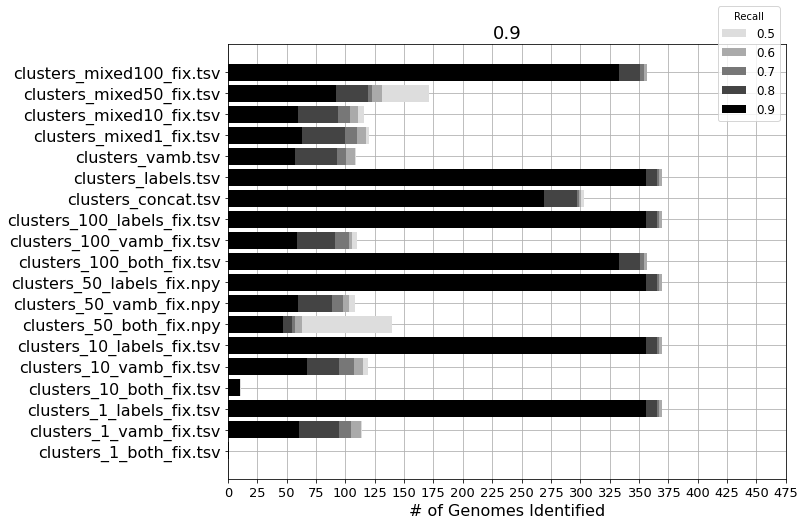

In [115]:
for precision in [0.9]:
    plt.figure(figsize=(10, 8))
    colors = ['#DDDDDD', '#AAAAAA', '#777777', '#444444', '#000000']
    recalls = [0.5, 0.6, 0.7, 0.8, 0.9]
    for y, bins in zip(range(len(all_clusters)), all_bins):
        for color, recall in zip(colors, recalls):
            plt.barh(y, bins.counters[0][(recall, precision)], color=color)

    plt.title(str(precision), fontsize=18)
    plt.yticks(list(range(len(all_clusters))), all_clusters, fontsize=16)
    plt.xticks([i*25 for i in range(20)], fontsize=13)
    plt.legend([str(i) for i in recalls], bbox_to_anchor=(1, 1.1), title='Recall', fontsize=12)
    
    if precision == 0.9:
        plt.xlabel('# of Genomes Identified', fontsize=16)
    plt.gca().set_axisbelow(True)
    plt.grid()

In [137]:
bins_concat, bins_labels, bins_vamb = bins_one
sup_levels = [1, 10, 50, 100]
bins_vamb_sup = [bins_one_fix[1], bins_one_fix[4], bins_one_fix[7], bins_one_fix[10]]
bins_labels_sup = [bins_one_fix[2], bins_one_fix[5], bins_one_fix[8], bins_one_fix[11]]

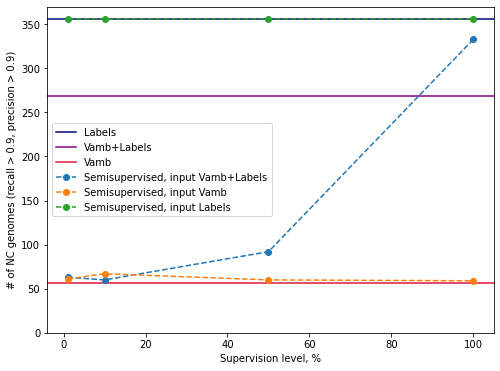

In [138]:
plt.figure(figsize=(8, 6))
rec, prec = 0.9, 0.9

plt.axhline(y=bins_labels.counters[0][(rec, prec)], color='navy', label='Labels')
plt.axhline(y=bins_concat.counters[0][(rec, prec)], color='purple', label='Vamb+Labels')
plt.axhline(y=bins_vamb.counters[0][(rec, prec)], color='crimson', label='Vamb')

plt.plot(sup_levels, [b.counters[0][(rec, prec)] for b in bins_fix], 'o--', label='Semisupervised, input Vamb+Labels')
plt.plot(sup_levels, [b.counters[0][(rec, prec)] for b in bins_vamb_sup], 'o--', label='Semisupervised, input Vamb')
plt.plot(sup_levels, [b.counters[0][(rec, prec)] for b in bins_labels_sup], 'o--', label='Semisupervised, input Labels')

plt.ylim((0, 370))
plt.ylabel('# of NC genomes (recall > 0.9, precision > 0.9)')
plt.xlabel('Supervision level, %')
plt.legend()
plt.show()